# Welcome to Lab 12: Greedy Algorithms 2

This lab, we will dive more into greedy algorithms that do produce optimal solutions for graph problems.

Throughout the exercise, you will be extending the classes by completing code stubs in their respective cells. You do not need to copy the code, it is enough to work in the cell under each exercise. Note that there are separate cells provided where you can (and should) test your code. During the exercises, you will (through customMagics) obtain a Python file (.py) which you should run against a set of unittests. Please avoid writing any unnecessary code in cells containing the `%%execwritefile` command. Doing this could alter the file `.py` and make it syntactically incorrect or interfere with the unittests. To prevent this stick to the following rules:'
 - ***Do not remove cells that start with ``%%execwritefile`` and do not remove that line.***
 - If a cell contains a `%%execwritefile` command at the top and a class definition you need to complete the given methods and adding helper methods is allowed, but do **not** add new functions or Python script to the cells (like global variables).
 - If a cell contains a `%%execwritefile` command at the top and **not** a class definition you must complete the given functions and you are free to add helper functions, new classes, and Python script that contains for example global variables. Note, that the use of global variables is almost always wrong except for a few use cases such as RNG for the numpy random generator methods.
 - If a cell does **not** contain a `%%execwritefile` command you can plot things, print variables, and write test cases. Here, you are free to do whatever you want.
 - If a cell does **not** contain a `%%execwritefile` command it should not contain functional code that is needed to run other functions or classes. The reason is that it is not copied to the `.py`. So, it can not be used during the unittesting.

You do not need to look at the `customMagic.py` nor do more than glimpse at the test file, your exercise is contained in this workbook unless specified differently in this notebook's instructions. 

***Hint: Jupyter Notebooks saves variables between runs. If you get unexpected results try restarting the kernel, this deletes any saved variables.*** 

Please fill in your student name down below

In [1]:
# FILL IN YOU STUDENT NUMBER
student = 3893995

# Set this to false if you want the default screen width.
WIDE_SCREEN = True

In [2]:
from custommagics import CustomMagics
import timeit

if WIDE_SCREEN:
    import notebook
    from IPython.display import display, HTML

    if int(notebook.__version__.split(".")[0]) >= 7:    
        display(HTML(
            '<style>'
                '.jp-Notebook { padding-left: 1% !important; padding-right: 1% !important; width:100% !important; } '
            '</style>'
        ))
    else:
        display(HTML("<style>.container { width:98% !important; }</style>"))

get_ipython().register_magics(CustomMagics)

In [3]:
%%execwritefile exercise12_{student}_notebook.py 0 

# DO NOT CHANGE THIS CELL.
# THESE ARE THE ONLY IMPORTS YOU ARE ALLOWED TO USE:

import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt

RNG = np.random.default_rng()

Writing exercise12_3893995_notebook.py


In [4]:
plt.matplotlib.rcParams['figure.figsize'] = [10, 5]

# 1.0 Dijkstra's Algorithm

Dijkstra's algorithm is one of the best known path finding algorithms and many algorithms have been based on it. A-star, for example, is such an algorithm that builds on Dijkstra. However, Dijkstra is in essence just a breadth-first search algorithm that reorders the queue based on some conditions. Also, a good thing to note is that the original paper of Dijkstra talks about finding the shortest path between source and destination, while nowadays people often mean finding the shortest path from a source node to all other nodes. In this exercise, we will implement the source node to all other nodes version of Dijkstra's algorithm.

On a programming note, Python has a lot of ways to implement a priority queue using libraries and it is highly recommended to use these resources. However, in this exercise, we will use a "plain" list as a priority queue and it is your job to make sure it is sorted correctly (and therefore functions as a priority queue). This is done to get a better understanding for what is happening, however, it is not optimal for performance.

Also, note that the `Graph` class can only make connected graphs. This is true for all exercises.

***Before, you start programming take a look at the `Graph` class and check what it can do.***

In [5]:
%%execwritefile exercise12_{student}_notebook.py 10 -a -s

class Graph():
    """
    An undirected graph (not permitting loops) class with the ability to color edges.
    
    Object attributes:
        :param adjacency_list: The representation of the graph.
        :type adjacency_list: dict[int, dict[int, int]]
    """    
    def __init__(self):
        """
        The graph is always initialized empty, use the `set_graph` method to fill it.
        """
        self.adjacency_list = {}
    
    def generate_random_graph(self, min_=6, max_=10):
        """
        This is a helper method to generate a random connected graph with random weights

        :param min_: The minimum size of the graph.
        :type min_: int
        :param max_: The maximum size of the graph.
        :type max_: int
        """
        size = RNG.integers(min_, max_)
        
        # add nodes
        self.adjacency_list = {i: {} for i in range(size)}

        # add edgesf
        node = int(RNG.integers(size))
        connected = {node}
        while len(connected) < size:
            # create between 1 and 5 edges for each node
            for edge in RNG.integers(size, size=RNG.integers(2, min(size, 5))):
                # skip self looping edges
                if edge == node:  
                    continue
                    
                self.adjacency_list[node][edge] = self.adjacency_list[edge][node] = RNG.integers(1, 10)  # undirected
                connected.add(edge)

            # create edges from a new node (which is the last edge from the current node)
            node = edge
            
    def set_graph(self, adjacency_list):
        """
        This method sets the graph using as input an adjacency list.

        :param adjacency_list: The representation of the weighted graph.
        :type adjacency_list: dict[int, dict[int, int]]
        """
        self.adjacency_list = adjacency_list

    def __getitem__(self, key):
        """
        A magic method that makes using keys possible.
        This makes it possible to use self[node] instead of self.adjacency_list[node], where node is an int.

        :return: The nodes that can be reached from the node `key` a.k.a the edges.
        :rtype: dict[int, int]
        """
        return self.adjacency_list[key]

    def get_random_node(self):
        """
        This returns a random node from the graph.
        
        :return: A random node
        :rtype: int
        """
        return RNG.choice(list(self.adjacency_list))

    def __repr__(self):
        """
        The representation of the graph
        """
        return repr(self.adjacency_list)
    
    def show(self, colored_edges=[], colored_nodes=[]):
        """
        This method shows the current graph.
        """
        n_vertices = len(self.adjacency_list)
        matrix = np.zeros((n_vertices, n_vertices))
        key_to_index = dict(zip(self.adjacency_list.keys(), range(n_vertices)))
        for vertex, edges in self.adjacency_list.items():
            for edge in edges:
                matrix[key_to_index[vertex], key_to_index[edge]] = 1
        
        graph = nx.from_numpy_array(matrix, create_using=nx.Graph)
        pos = nx.nx_agraph.graphviz_layout(graph, prog="circo")
        nx.draw_networkx(graph,
                         pos=pos,
                         labels=dict(enumerate(self.adjacency_list.keys())),
                         with_labels=True,
                         node_size=500,
                         width=1.5,
                         node_color=['g' if node in colored_nodes else 'b' for node in self.adjacency_list],
                         edge_color=["r" if edge in colored_edges or (edge[1], edge[0]) in colored_edges else "k" for edge in graph.edges])
        nx.draw_networkx_edge_labels(graph,
                                     pos=pos,
                                     edge_labels={edge: str(self.adjacency_list[edge[0]][edge[1]]) for edge in graph.edges})
        plt.show()

Appending to exercise12_3893995_notebook.py


In [6]:
%%execwritefile exercise12_{student}_notebook.py 100 -a -s

class Dijkstra():
    """
    This call implements Dijkstra's algorithm and has at least the following object attributes after the object is called:
    Attributes:
        :param priorityqueue: A priority queue that contains all the nodes that need to be visited including the distances it takes to reach these nodes.
        :type priorityqueue: list[tuple[int, int]]
        :param history: A dictionary containing the nodes that will be visited and 
                        as values the node that leads to this node and
                        the distance it takes to get to this node.
        :type history: dict[int, tuple[int, int]]
    """
    
    def __call__(self, graph, source, show_intermediate=True):
        """
        This method finds the fastest path from the source to all other nodes.

        :param graph: The graph on which the algorithm is used.
        :type graph: Graph
        :param source: The source node from which the fastest path needs to be found.
        :type source: int
        :param show_intermediate: This determines if intermediate results are shown.
                                  You do not have to do anything with the parameters as it is already programmed.
        :type show_intermediate: bool
        :return: A list of edges that make up all shortest paths
        :rtype: list[tuple[int]]
        """
        self.graph = graph
        self.show_intermediate = show_intermediate
        self.priorityqueue = [(source, 0)]
        self.history = {source: (None, 0)}

        self.main_loop()
        return self.find_shortest_edges()     

    def find_shortest_edges(self):
        """
        This method finds the shortest edge that creates the shortest paths between the source node and all other nodes.
        
        :return: A list of edge that form the optimal paths.
        :rtype: list[tuple[int]]
        """
        edges = []
        for node, (prev, _) in self.history.items():
            if prev is not None:
                edges.append((prev, node))
        return edges     

    def main_loop(self):
        """
        This method contains the logic for Dijkstra's algorithm

        It does not have any inputs nor outputs. 
        Hint, use object attributes to store results.
        """
        if self.show_intermediate:
            print("The green nodes indicate the current node that is explored.\nThe red edges indicate the current optimal edge.")
        
        while self.priorityqueue:
            # Get the node with the smallest distance
            self.priorityqueue.sort(key=lambda x: x[1])
            current_node, current_dist = self.priorityqueue.pop(0)

            for neighbor, weight in self.next_step(current_node):
                self.step(current_node, neighbor, weight)

            # This shows each step of Dijkstra's algorithm. 
            if self.show_intermediate:
                self.graph.show(self.find_shortest_edges(), [current_node])

    
    def step(self, node, new_node, weight):
        """
        One step in the Dijkstra algorithm. 

        :param node: The current node
        :type node: int
        :param new_node: The next node that can be visited from the current node
        :type new_node: int
        :param weight: The weight of the edge between the node and new_node
        :type weight: int
        """
        new_distance = self.history[node][1] + weight

        if new_node not in self.history or new_distance < self.history[new_node][1]:
            self.history[new_node] = (node, new_distance)
            self.priorityqueue.append((new_node, new_distance))
    
    def next_step(self, node):
        """
        This method returns the next possible actions.

        :param node: The current node
        :type node: int
        :return: A list with possible next nodes and their weights that can be visited from the current node.
        :rtype: list[tuple[int, int]]
        """
        return list(self.graph[node].items())


Appending to exercise12_3893995_notebook.py


## Test your code

In the cell below, you can test your `Dijkstra` class.

The green nodes indicate the current node that is explored.
The red edges indicate the current optimal edge.


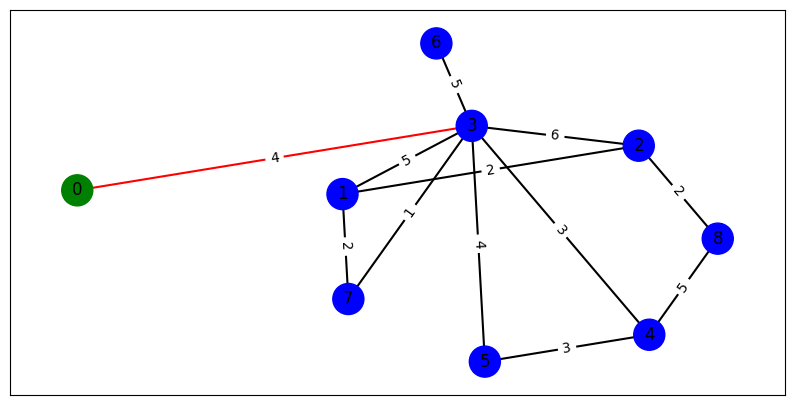

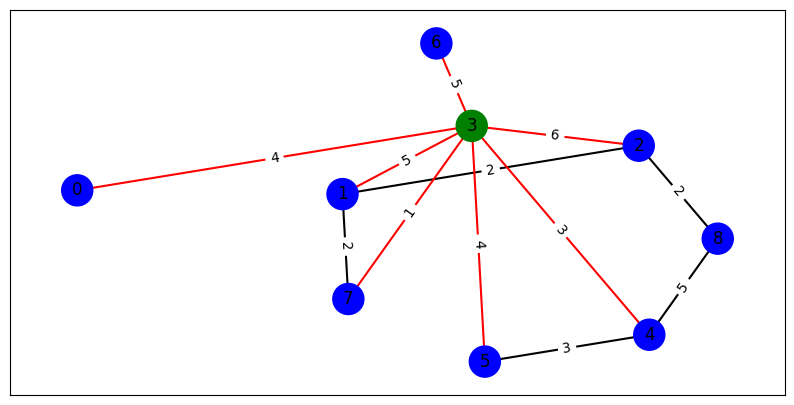

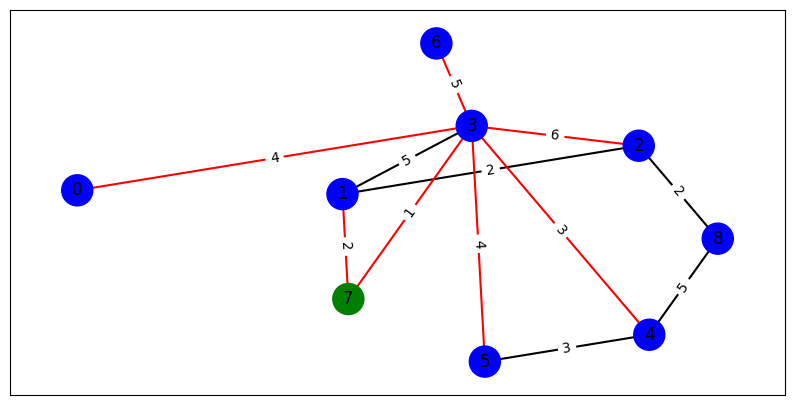

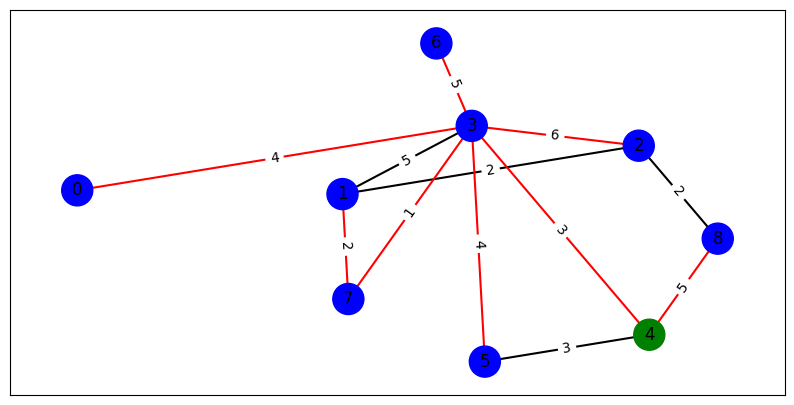

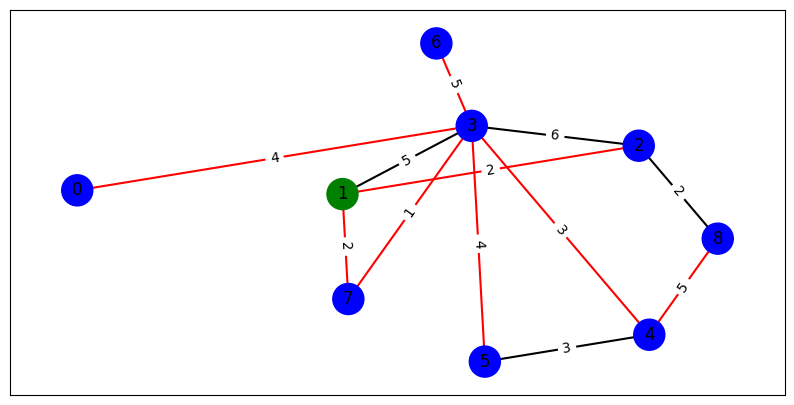

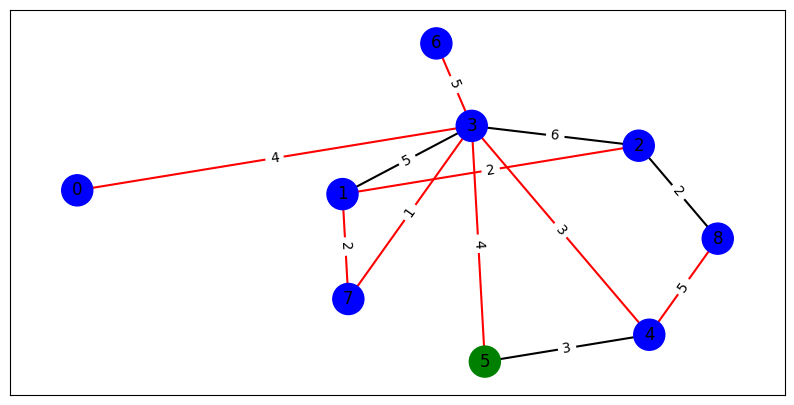

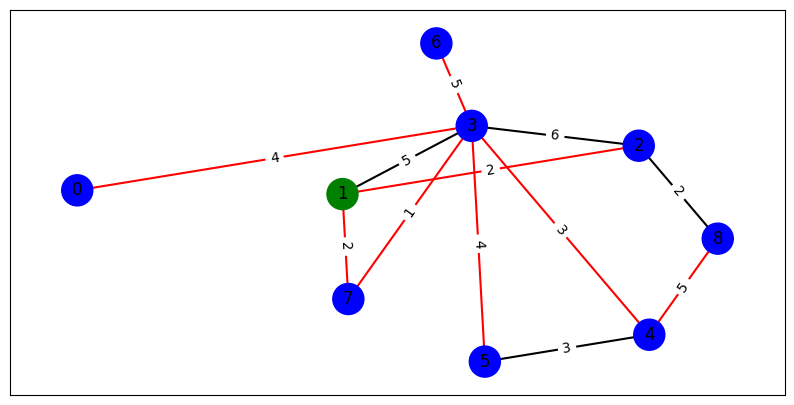

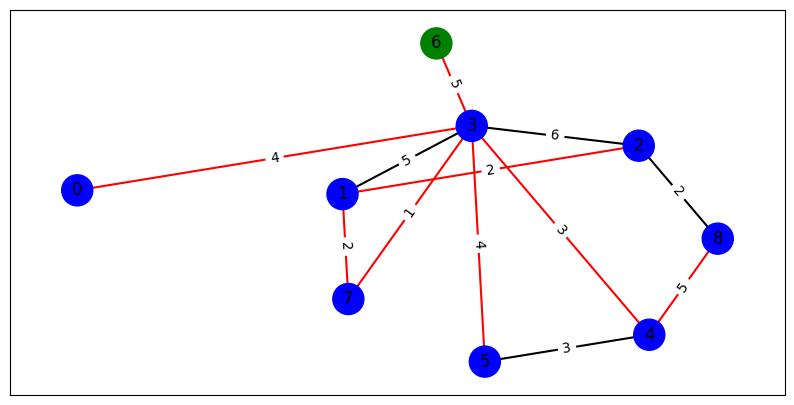

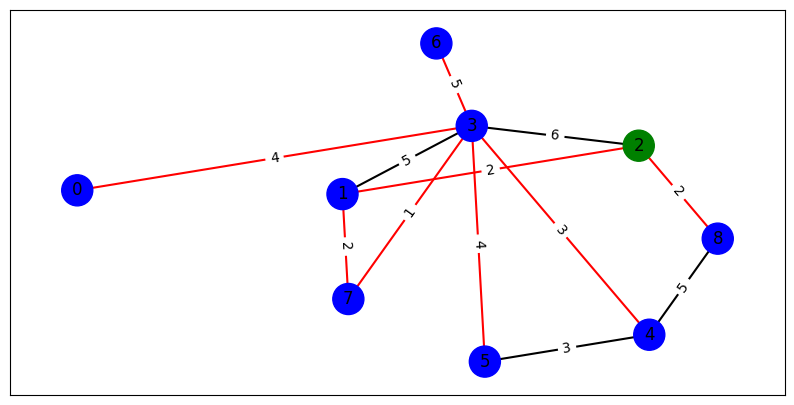

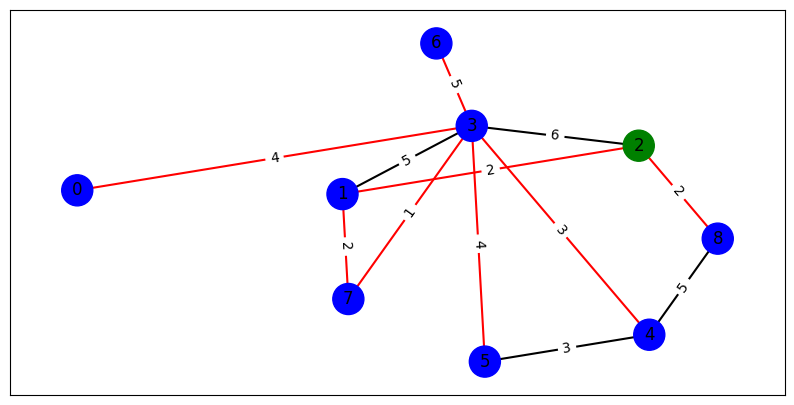

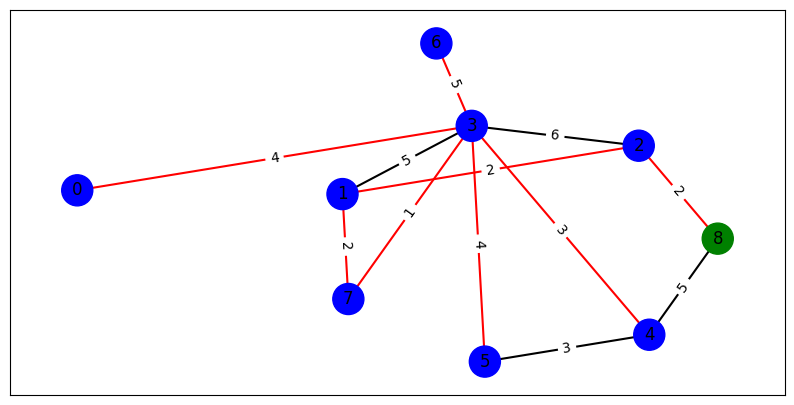

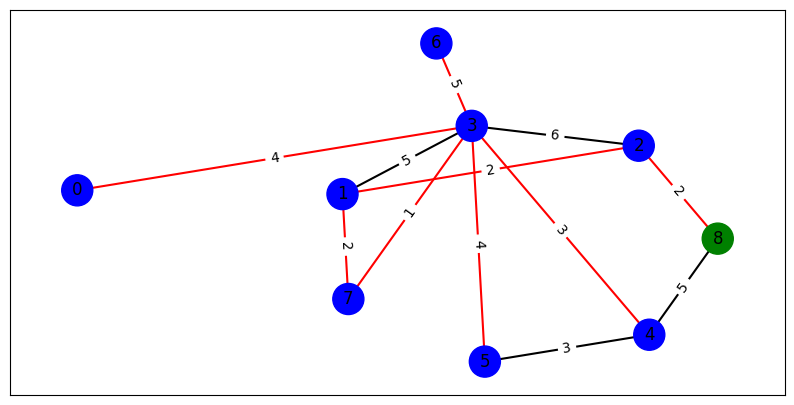

The shortest edges from node 0 to all other nodes are [(0, 3), (1, 2), (3, 7), (3, 4), (3, 5), (7, 1), (3, 6), (2, 8)]


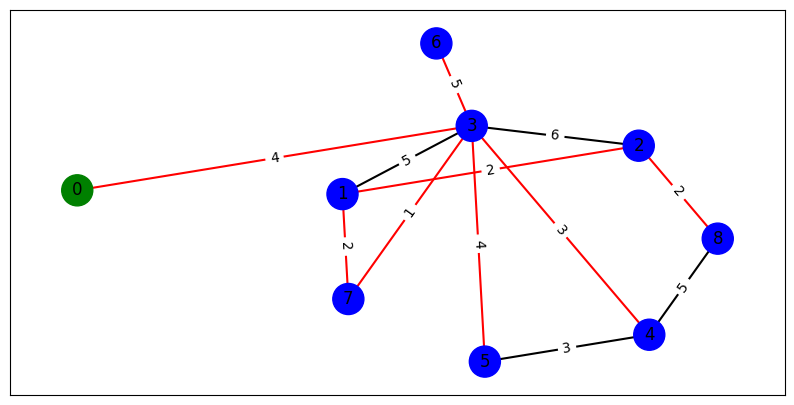

In [7]:
# Type your testing code here
graph = Graph()
graph.generate_random_graph()
source_node = graph.get_random_node()
fastest_edges = Dijkstra()(graph, source_node)
print(f"The shortest edges from node {source_node} to all other nodes are {fastest_edges}") 
graph.show(fastest_edges, [source_node])


# 2.0 Prim's Algorithm

Prim's algorithm is a way to make a minimal spanning tree from an undirected weighted graph. This tree has as a property that the sum of its edges is minimal given the undirected weighted graph. In other words, if you try to minimize the sum of the edges of a graph by removing edges while keeping the graph connected, you get the result of Prim's algorithm. 

The general idea of the algorithm is that you start at a random node and with each step, you add an edge to an unvisited node that currently has the least weight. You repeat this step until all nodes are visited and the edges used to visit these nodes form your minimal spanning tree. See the lecture for a full explanation of Prim's algorithm.


In [8]:
%%execwritefile exercise12_{student}_notebook.py 200 -a -s

class Prim():
    """
    This call implements Prim's algorithm and has at least the following object attributes after the object is called:
    Attributes:
        :param priorityqueue: The priority queue that is used to determine which node is explored next
        :type priorityqueue: list[tuple[int, int]]
        :param history: The history of nodes that are visited in the algorithm
        :type history: set[int]
        :param edges: A dictionary that contains which edge is kept
        :type edges: dict[int, int]
    """
    
    def __call__(self, graph, show_intermediate=True):
        """
        This method finds a minimal spanning tree.

        :param graph: The graph on which the algorithm is used.
        :type graph: Graph
        :param show_intermediate: This determines if intermediate results are shown.
                                  You do not have to do anything with the parameters as it is already programmed.
        :type show_intermediate: bool
        :return: A list of edges that make up the minimal spanning tree.
        :rtype: list[tuple[int]]
        """
        self.graph = graph
        self.show_intermediate = show_intermediate
        
        source = graph.get_random_node()
        self.priorityqueue = [(source, 0)]
        self.history = {source}
        self.edges = {}
        
        self.main_loop()
        return list(self.edges.items())    

    def main_loop(self):
        """
        This method contains the logic of Prim's Algorithm

        It does not have any inputs nor outputs. 
        Hint, use object attributes to store results.
        """
        if self.show_intermediate:
            print("All nodes that are in history are colored green.\nThe minimal edge are colored red, given the history.")
        
        while self.priorityqueue:
            # Get the node with the smallest edge weight
            self.priorityqueue.sort(key=lambda x: x[1])
            current_node, current_weight = self.priorityqueue.pop(0)

            for neighbor, weight in self.next_step(current_node):
                self.step(current_node, neighbor, weight)

            # This shows each step of Prim's algorithm. 
            if self.show_intermediate:
                self.graph.show(list(self.edges.items()), list(self.history))

    def step(self, node, new_node, new_weight):
        """
        One step in Prim's algorithm. 
        
        :param node: The current node
        :type node: int
        :param new_node: The next node that can be visited from the current node
        :type new_node: int
        :param new_weight: The weight of the edge between the node and new_node
        :type new_weight: int
        """
        if new_node not in self.history:
            self.history.add(new_node)
            self.edges[(node, new_node)] = new_weight
            self.priorityqueue.append((new_node, new_weight))

    def next_step(self, node):
        """
        This method returns the next possible actions.

        :param node: The current node
        :type node: int
        :return: A list with possible next nodes and their weights that can be visited from the current node.
        :rtype: list[tuple[int, int]]
        """
        return list(self.graph[node].items())

Appending to exercise12_3893995_notebook.py


## Test your code

In the cell below, you can test your `Prim` class.

All nodes that are in history are colored green.
The minimal edge are colored red, given the history.


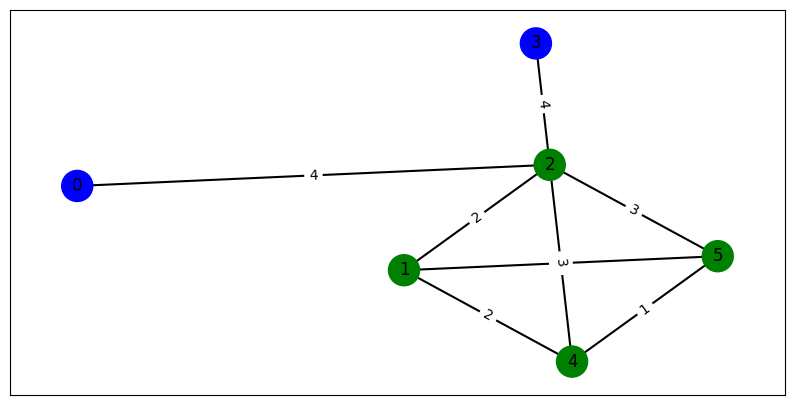

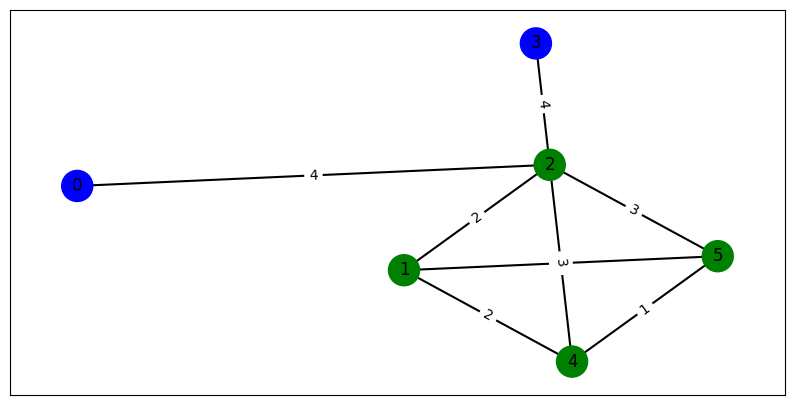

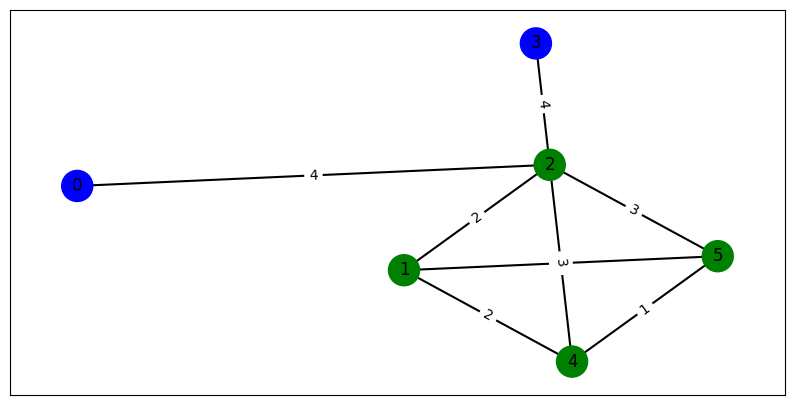

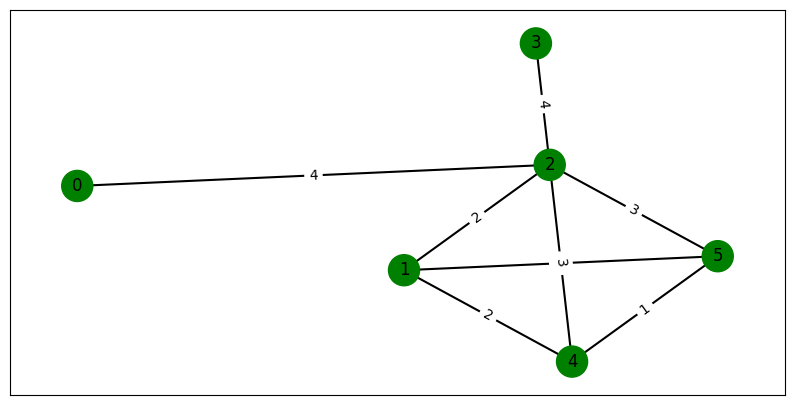

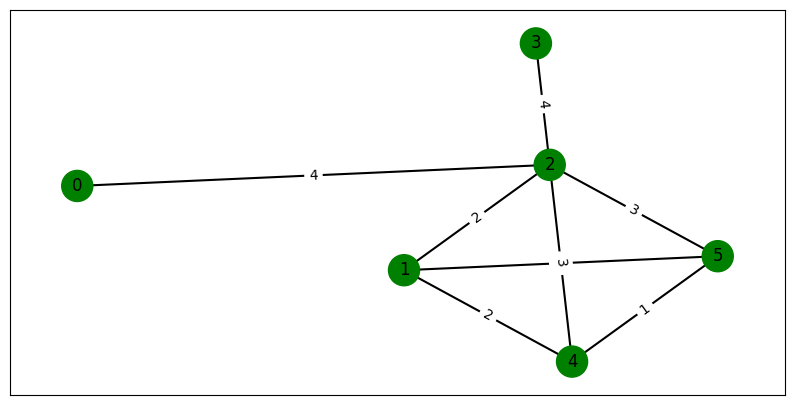

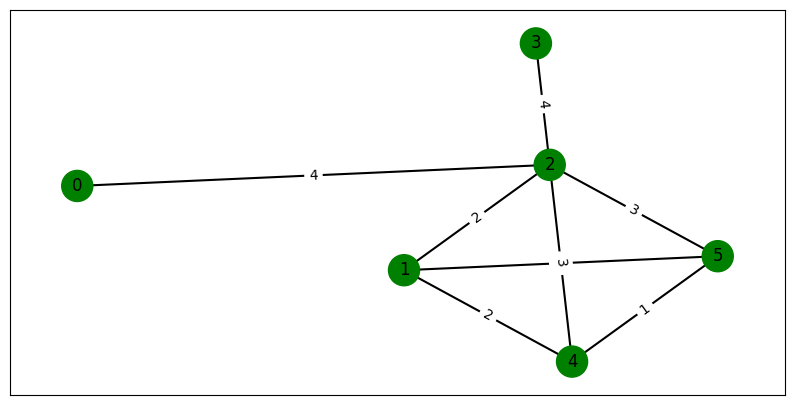

The minimal spanning tree consists of the following edges [((5, 4), 1), ((5, 2), 3), ((5, 1), 2), ((2, 0), 4), ((2, 3), 4)]


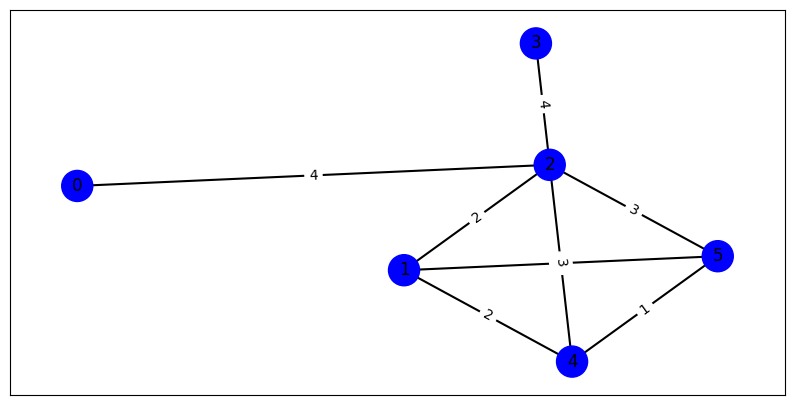

In [9]:
# Type your testing code here
graph = Graph()
graph.generate_random_graph()
fastest_edges = Prim()(graph)
print(f"The minimal spanning tree consists of the following edges {fastest_edges}") 
graph.show(fastest_edges)


# 3.0 Kruskal's Algorithm

In the previous exercise, we implemented Prim's algorithm, and while it is a good algorithm there are more algorithms to find a minimal spanning tree of a graph. In this exercise, we will focus on Kruskal's Algorithm. This algorithm works a bit differently. Here we start by making a forest of nodes, where each tree in the forest consists of one node. As a general note, a forest is a collection of trees. The idea of the algorithm is that each tree is disjoint (not connected) of all other trees in the forest. The next "starting" step is sorting all edge of the graph by weight.

Now, with each step, we will take the edge with the smallest weight and check if it connects two trees together or if it makes a single tree into a circular graph. If it is the first answer then we add the edge to the minimal spanning tree otherwise we don't. Continue until either all edge are checked or there is only a single tree left in the forest. See the lecture for a full explanation of Kruskal's algorithm.

It is always good to think why there are multiple algorithms and why you want to use one or the other. Try to answer the following questions while you are creating the algorithm. Think about which algorithm is best suited for a dense graph (each node has a lot of edges) or a sparse graph (each node has only a few edges). Is the complexity different between the algorithms and what is this complexity?

***Important note, in this exercise, we do not use the union-find or disjoint-set datastructure! We do use a list of sets as a simplified version, you need to implement this in `Forest`. The algorithm is still the same only slower as the datastructure is not optimal.***

In [10]:
%%execwritefile exercise12_{student}_notebook.py 300 -a -s

class Forest():
    """
    This is a datastructure class for a forest of trees.
    It has the following attribute:
        :param trees: The trees in the forest.
        :type trees: list[set[int]]
    """
    def __init__(self, size):
        """
        This initializes the forest object, where the size of the forest is the number of trees
        and each tree consist of one element (in Kruskal's algorithm this would be a node).

        :param size: The size of the forest
        :type size: int
        """
        self.trees = [{i} for i in range(size)]

    def union_tree(self, tree1, tree2):
        """
        This method creates the union of two trees.

        :param tree1: One of the trees that needs to be merged.
        :type tree1: int
        :param tree2: One of the trees that needs to be merged.
        :type tree2: int
        """
        self.trees[tree1].update(self.trees[tree2])
        self.trees.pop(tree2)

    def find_tree(self, element):
        """
        This method finds to which tree a element belongs and
        returns the index of this tree.

        :param element: The element that we want to find (in Kruskal this would be node).
        :type element: int
        :return: The index of the tree in the forest list.
        :rtype: int
        """
        for i, tree in enumerate(self.trees):
            if element in tree:
                return i
        return None
            
class Kruskal():
    """
    This call implements Kruskal's algorithm and has at least the following object attributes after the object is called:
    Attributes:
        :param queue: The priority queue that is used to determine which edge is explored next
        :type queue: list[tuple[int]]
        :param forest: The forest for Kruskal's algorithm
        :type forest: Forest
        :param edges: A list of edges that contains which edge is kept
        :type edges: list[tuple[int]]
    """
    
    def __call__(self, graph, show_intermediate=True):
        """
        This method finds a minimal spanning tree.

        Note, that you need to use the attribute names given above.

        Hint: You might need more attributes then the list given above.

        :param graph: The graph on which the algorithm is used.
        :type graph: Graph
        :param show_intermediate: This determines if intermediate results are shown.
                                  You do not have to do anything with the parameters as it is already programmed.
        :type show_intermediate: bool
        :return: A list of edges that make up the minimal spanning tree.
        :rtype: list[tuple[int]]
        """
        self.show_intermediate = show_intermediate
        self.graph = graph
        self.queue = self.sort_edges()
        self.forest = self.create_forest()
        self.edges = []

        self.main_loop()
        return [(int(edge[0]), int(edge[1])) for edge in self.edges]

    def create_forest(self):
        """
        This method creates the initial forest of trees for Kruskal's algorithm given a graph.

        :return: A forest of trees each tree containing one node
        :rtype: Forest
        """
        return Forest(len(self.graph.adjacency_list))

    def sort_edges(self):
        """
        This method sorts the edges in ascending order from smallest weight to largest.
        
        Hint 1: For Kruskal's algorithm you only need one edge either from node A to B or from node B to A.
                So, you can essentially return the edges of any directed graph that corresponds to the undirect graph.
        Hint 2: You can sort a list using sorted with a function for each item. 
                For example, a function that lets you sort the list of tuples on the third item of each tuple.
                Have a look at the `key` argument of `sorted` if you want to know how to do this.

        :return: A list with all sorted edges without their weights.
        :rtype: list[tuple[int]]
        """
        edges = []
        for node, neighbors in self.graph.adjacency_list.items():
            for neighbor, weight in neighbors.items():
                if (neighbor, node) not in edges:
                    edges.append((node, neighbor, weight))
        return sorted(edges, key=lambda x: x[2])

    def main_loop(self):
        """
        This method contains the logic of Kruskal's Algorithm

        It does not have any inputs nor outputs. 
        Hint, use object attributes to store results.
        """
        if self.show_intermediate:
            print("The nodes of the current edge are colored green.\nThe current minimal edge are colored red.")

        while self.queue:
            edge = self.queue.pop(0)
            node1, node2, weight = edge
            tree1 = self.forest.find_tree(node1)
            tree2 = self.forest.find_tree(node2)

            if tree1 != tree2:
                self.edges.append((int(node1), int(node2)))
                self.forest.union_tree(tree1, tree2)

                if self.show_intermediate:
                    self.graph.show(self.edges, [node1, node2])

    def step(self, edge):
        """
        One step in Kruskal's algorithm. 
        
        :param edge: The current edge that we are exploring
        :type edge: tuple[int]
        """
        node1, node2, weight = edge
        tree1 = self.forest.find_tree(node1)
        tree2 = self.forest.find_tree(node2)

        if tree1 != tree2:
            self.edges.append((int(node1), int(node2)))  # Ensure the nodes are integers
            self.forest.union_tree(tree1, tree2)


Appending to exercise12_3893995_notebook.py


## Test your code

In the cell below, you can test your `Kruskal` class.

The nodes of the current edge are colored green.
The current minimal edge are colored red.


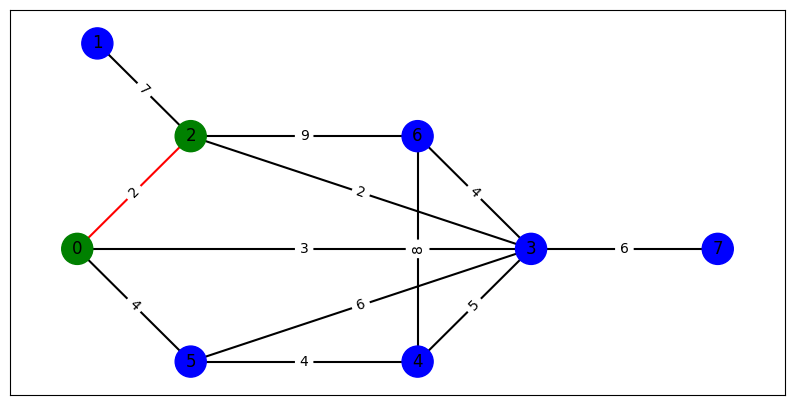

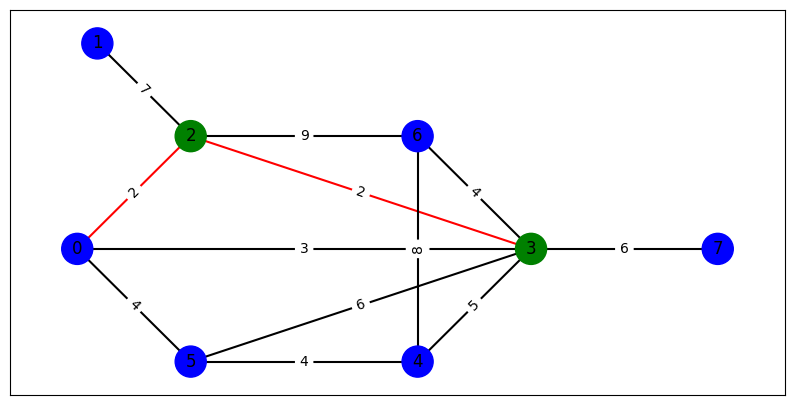

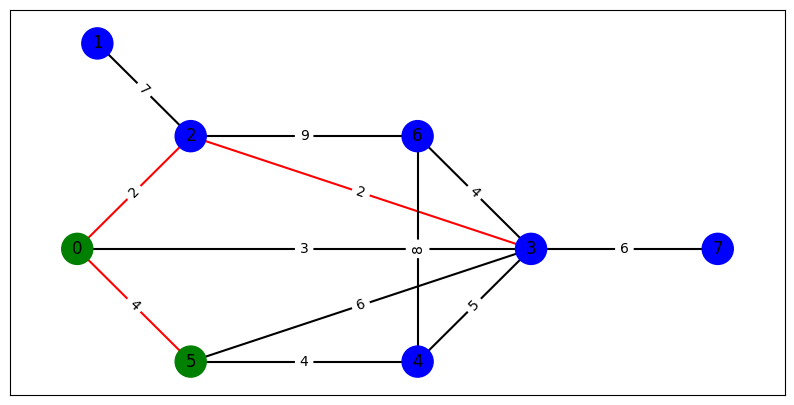

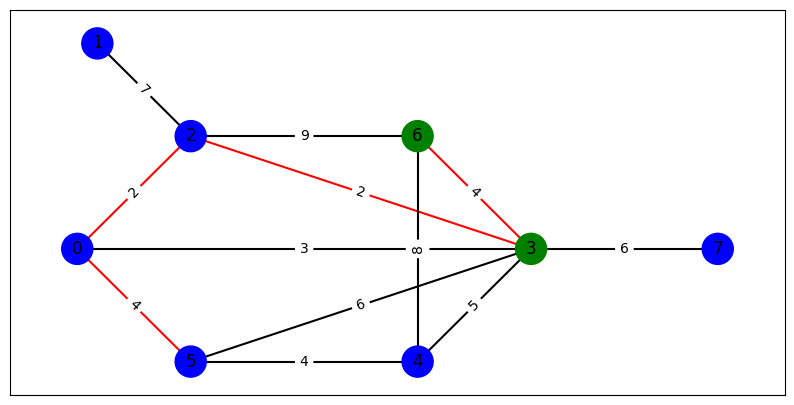

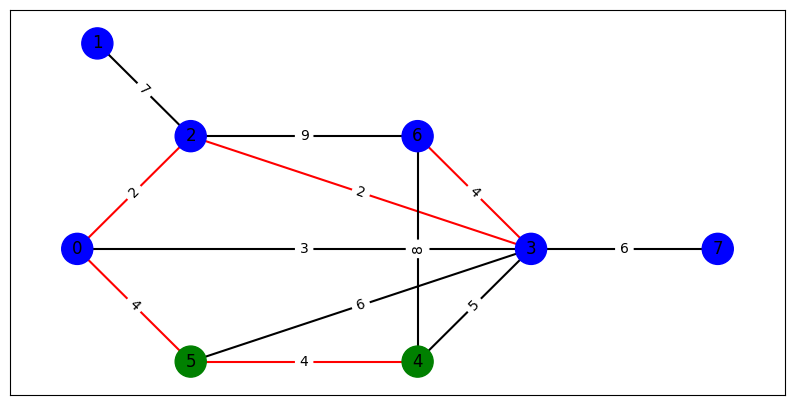

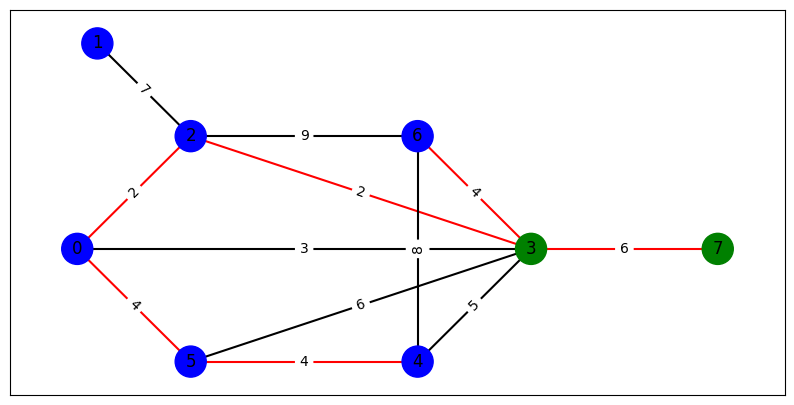

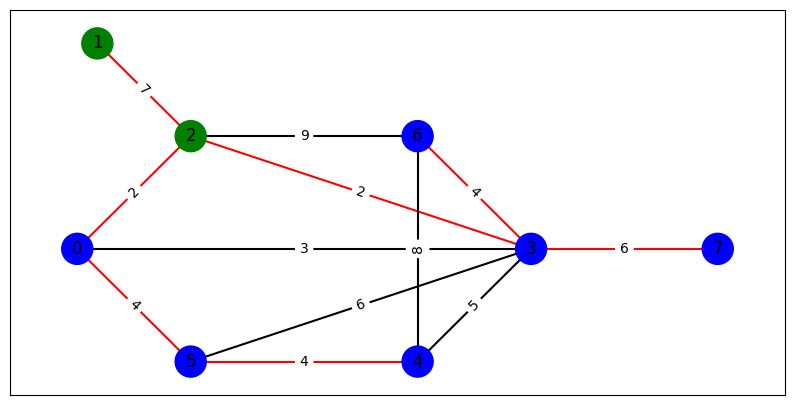

The minimal spanning tree consists of the following edges [(0, 2), (2, 3), (0, 5), (3, 6), (4, 5), (3, 7), (1, 2)]


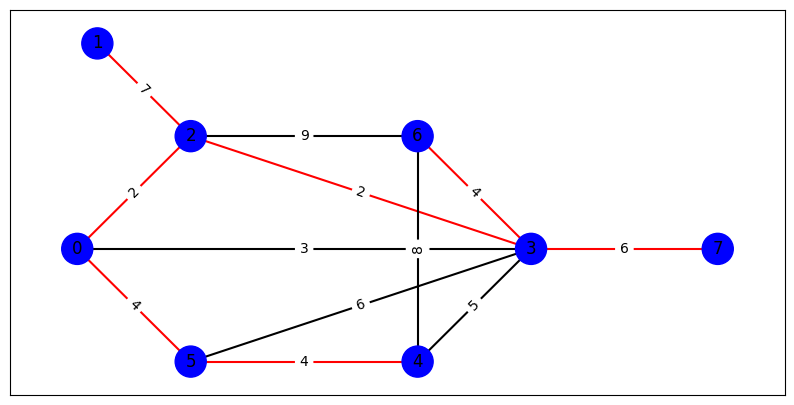

In [11]:
# Type your testing code here
graph = Graph()
graph.generate_random_graph()
fastest_edges = Kruskal()(graph)
print(f"The minimal spanning tree consists of the following edges {fastest_edges}") 
graph.show(fastest_edges)


## 3.1 Kruskal's Algorithm (Hard Exercise)

### **Note, that the following exercise is harder than average!**

Here, we will implement Kruskal's Algorithm again with a union-find or disjoint-set datastructure, however, it is not mandatory to optimize the algorithm to make the search paths minimal. To do this, we can use the same algorithm as before so inherit `Kruskal` (hear copy-paste) but we need to overwrite the `create_forest` method, where we now use a `ForestFast` object.

In the lecture, you can find an extensive explanation of how this datastructure should work. In short, we create an array where each index is (part of) a tree. The value is either negative signaling the root of the tree or a positive number that links the parent in the tree. For example, if we have the following array `[1, -1]` then there is one tree where the second index is the root of the tree and the first index points towards the second thus the second index is the parent of the first index.

Optionally, you can optimize the datastructure a bit by using the negative numbers as the size of the tree. So `-1` would be a tree of length 1 and the previous example would look like this `[1, -2]`.

In [12]:
%%execwritefile exercise12_{student}_notebook.py 310 -a -s

class ForestFast():
    """
    This is a datastructure class for a forest of trees.
    It has the following attribute:
        :param trees: The trees in the forest (in Kruskal size is the number of nodes).
        :type trees: np.ndarray(int, (size,))
    """
    def __init__(self, size):
        """
        This initializes the forest object, where the size of the forest is the number of trees
        and each tree consists of one element (in Kruskal's algorithm this would be a node).

        Thi

        :param size: The size of the forest
        :type size: int
        """
        self.trees = np.arange(size, dtype=int)

    def union_tree(self, tree1, tree2):
        """
        This method creates the union of two trees.

        :param tree1: One of the trees that needs to be merged.
        :type tree1: int
        :param tree2: One of the trees that needs to be merged.
        :type tree2: int
        """
        self.trees[self.trees == tree2] = tree1

    def find_tree(self, element):
        """
        This method finds to which tree a element belongs and
        returns the index of this tree.

        :param element: The element that we want to find (in Kruskal this would be node).
        :type element: int
        :return: The index of the tree in the forest list.
        :rtype: int
        """
        return int(self.trees[element])

class KruskalFast(Kruskal):
    """
    This call implements Kruskal's algorithm and has at least the following object attributes after the object is called:
    Attributes:
        :param queue: The priority queue that is used to determine which edge is explored next
        :type queue: list[tuple[int]]
        :param forest: The forest for Kruskal's algorithm
        :type forest: ForestFast
        :param edges: A list of edges that contains which edge is kept
        :type edges: list[tuple[int]]
    """
    def create_forest(self):
        """
        This method creates the initial forest of trees for Kruskal's algorithm given a graph.

        :return: A forest of trees each tree containing one node
        :rtype: ForestFast
        """
        return ForestFast(len(self.graph.adjacency_list))

Appending to exercise12_3893995_notebook.py


## Test your code

In the cell below, you can test your `Kruskal` class.

The nodes of the current edge are colored green.
The current minimal edge are colored red.


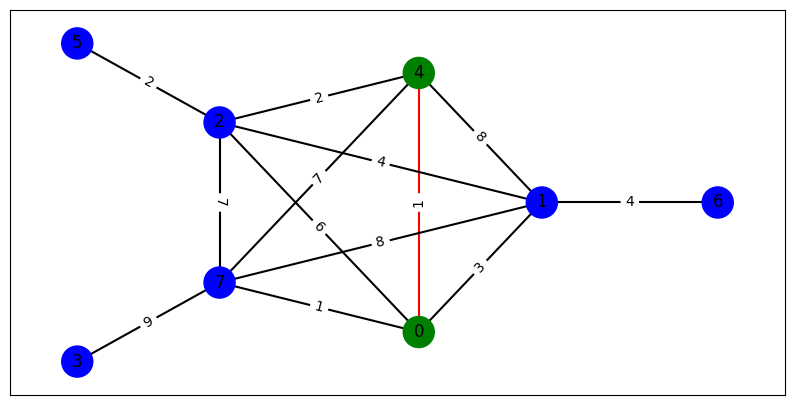

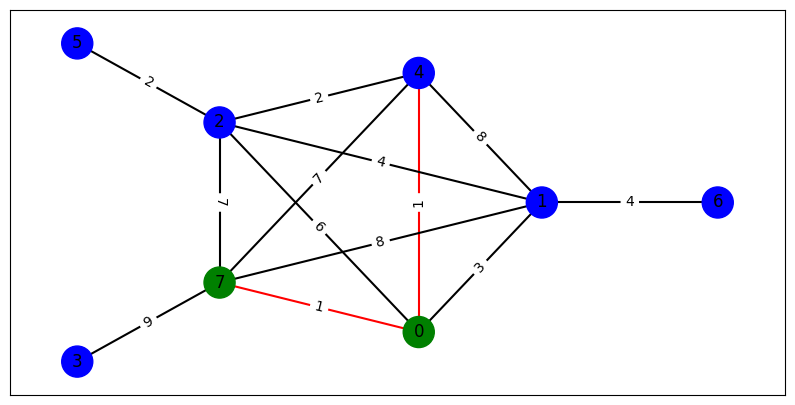

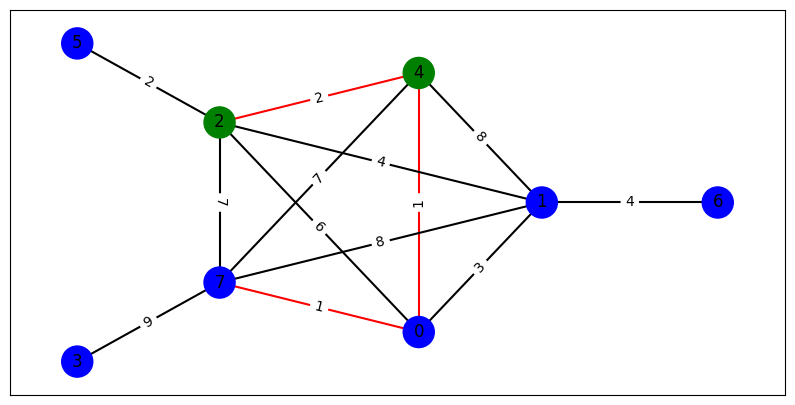

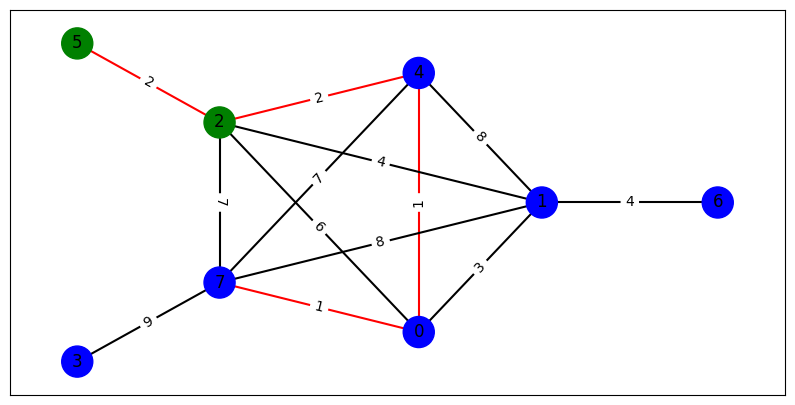

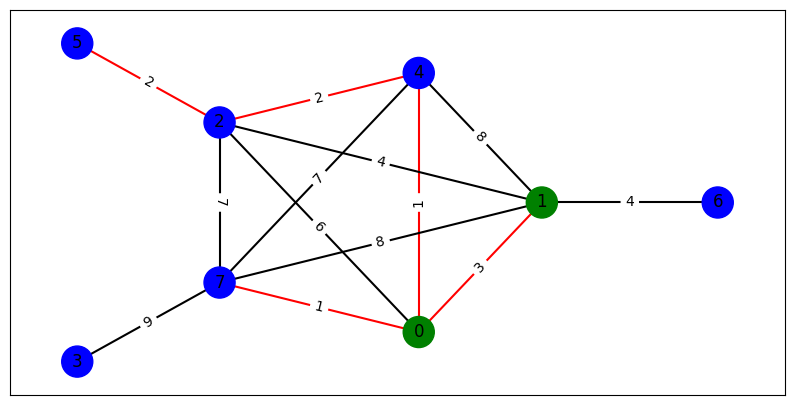

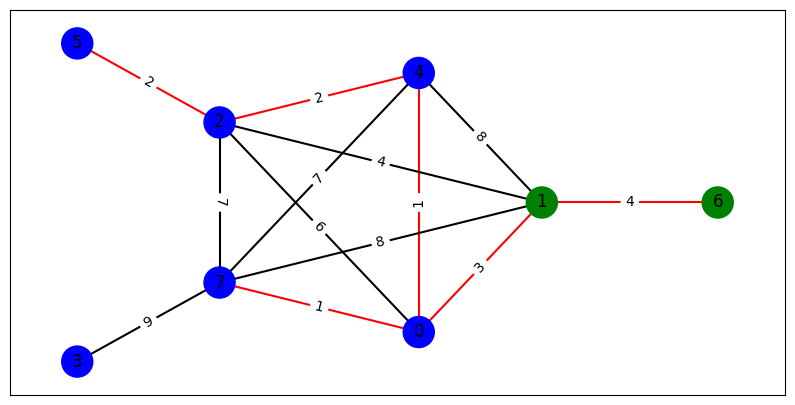

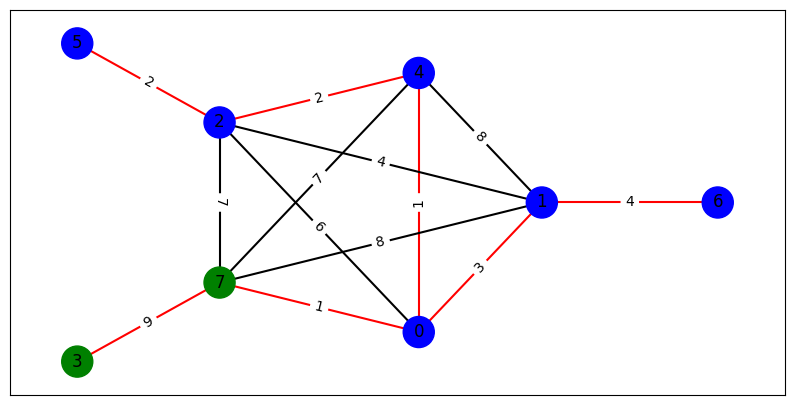

The minimal spanning tree consists of the following edges [(0, 4), (0, 7), (2, 4), (2, 5), (0, 1), (1, 6), (3, 7)]


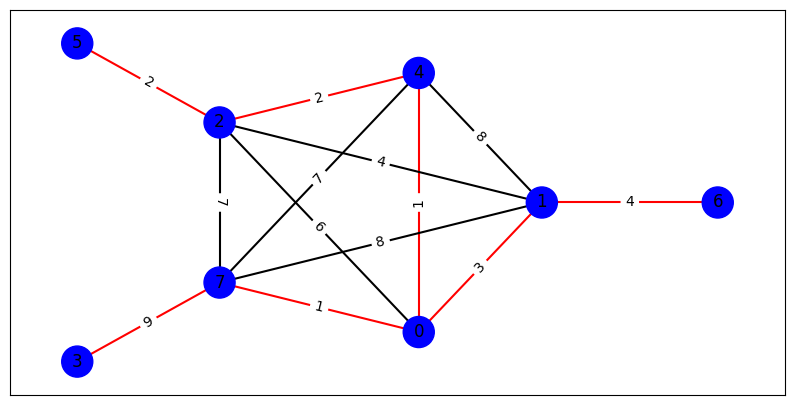

In [13]:
# Type your testing code here
graph = Graph()
graph.generate_random_graph()
fastest_edges = KruskalFast()(graph, True)
print(f"The minimal spanning tree consists of the following edges {fastest_edges}") 
graph.show(fastest_edges)

# 4.0 UNITTESTS

During this assignment, we copied all your code to the following **.py** file **"exercise12_{student}_notebook.py"**. You also tested your code along the way. However, it is possible that there are still a few errors. Therefore, it is good to run some unittest when you complete all coding. This gives you an extra chance to spot mistakes. Here, we added some unittest for you to use. Note, that they are merely a check to see if your **.py** is correct.

From this point onwards we strongly advise renaming the **"exercise12_{student}_notebook.py"** file to the correct file name that you need to hand in **"exercise12_{student}.py"**. Now, you can adjust the **"exercise12_{student}.py"** file without the risk of overwriting it when you run the notebook again. This also enables the possibility to run the unittests. Note, that from now on if you make a change in the Python file and you want to go back to the notebook later that you also make this change in the notebook. To run the unittests go to the **"unit_test.py"** file and run the file in either PyCharm, VSCode, or a terminal. You can run it in a terminal using the following command: `python -m unittest --verbose unit_test.py`. `--verbose` is optional but gives you more details about which tests fail and which succeed.

You are allowed to add your own unittests. 

## Uploading to Brightspace for Bonus

Next, you can upload your Python file with the correct name on brightspace in the bonus assignment. Follow the instructions on this brightspace page carefully to have a successful submission. After you get the feedback for this exercise you can either continue working in the Python file to fix possible bugs or you can go back to the notebook and remake the Python file. ***Please be careful, do not update your code in both the Python file and notebook at the same time!***. If you go back to the notebook do not forget to update the notebook with any changes you made within the Python file. In this case, it is best to just delete the Python file as soon as you copied all changes.

***NOTE, that you can now also upload the exercises from week 1! The process is exactly the same only there is no unittest.***